In [1]:
%matplotlib inline

## Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, models

import os
import time
import copy
import numpy as np
import pandas as pd


import imgaug as ia
import matplotlib.pyplot as plt

from imgaug import augmenters as iaa
from PIL import Image
from tqdm import tqdm_notebook as tqdm

In [3]:
plt.style.use('seaborn-darkgrid')

## Loading and preparing data

In [4]:
def prepare_df(df, images_directory, mapping):
    df['path'] = df['id'].apply(lambda fid: os.path.join(images_directory, f'{fid}.png'))
    df['label'] = df['label'].apply(lambda x: mapping[x])
    return df.drop('id', axis=1)


def split_train_test(df, test_part=0.25, shuffle=False, seed=None):
    if shuffle:
        df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    
    split_point = int(len(df) * test_part)
    train_df, test_df = df.iloc[split_point:], df.iloc[:split_point]
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

#### Paths to data

In [5]:
train_dir = '../data/train/'
train_img_dir = os.path.join(train_dir, 'images')
train_labels_csv = os.path.join(train_dir, 'trainLabels.csv')

#### Class mapping [str -> int]

In [6]:
classes = {
    'airplane': 0,
    'automobile': 1,
    'bird': 2,
    'cat': 3,
    'deer': 4,
    'dog': 5,
    'frog': 6,
    'horse': 7,
    'ship': 8,
    'truck': 9, 
}

#### Load csv to dataframe

In [7]:
seed = 123
mult_factor = 3

df = pd.read_csv(train_labels_csv)
df = prepare_df(df, train_img_dir, classes)
train_df, valid_df = split_train_test(df, test_part=0.1, shuffle=True, seed=seed)
train_df = pd.concat([train_df] * mult_factor, ignore_index=True)

#### Train dataframe

In [8]:
print(f'Total train images: {len(train_df)}\n\n')
train_df.head()

Total train images: 135000




,label,path
0,7,../data/train/images/17813.png
1,6,../data/train/images/32213.png
2,2,../data/train/images/14904.png
3,0,../data/train/images/3690.png
4,8,../data/train/images/22215.png


In [9]:
print(f'Total valid images: {len(valid_df)}\n\n')
valid_df.head()

Total valid images: 5000




,label,path
0,4,../data/train/images/11873.png
1,2,../data/train/images/40829.png
2,1,../data/train/images/36401.png
3,2,../data/train/images/5167.png
4,8,../data/train/images/30274.png


### Visualise some photos

In [10]:
def visualise_data(df, mapping, examples_per_cat=10):
    fig, axes = plt.subplots(nrows=len(mapping), ncols=examples_per_cat, figsize=(10, 10))
    for name, idx in mapping.items():
        examples = df[df['label'] == idx].sample(examples_per_cat)['path'].values
        for i, path in enumerate(examples):
            img = plt.imread(path)
            axes[idx, i].imshow(img, aspect='auto')
            axes[idx, i].get_xaxis().set_ticks([])
            axes[idx, i].get_yaxis().set_ticks([])
            if i == 0:
                axes[idx, i].set_ylabel(name)
    plt.yticks(range(10), range(10))
    plt.show()

#### Training images

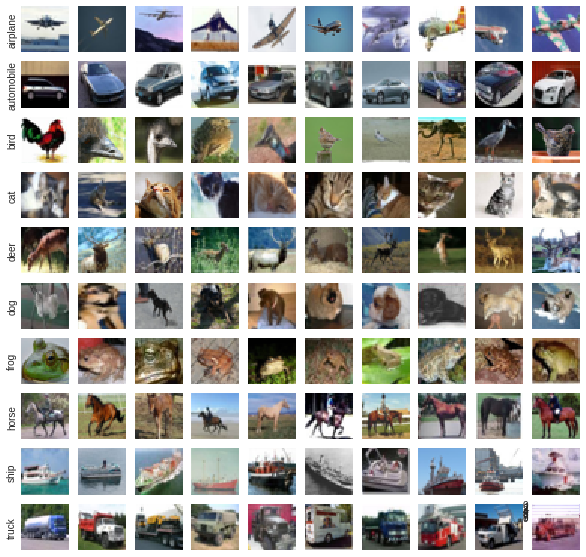

In [11]:
visualise_data(train_df, classes, 10)

#### Test images

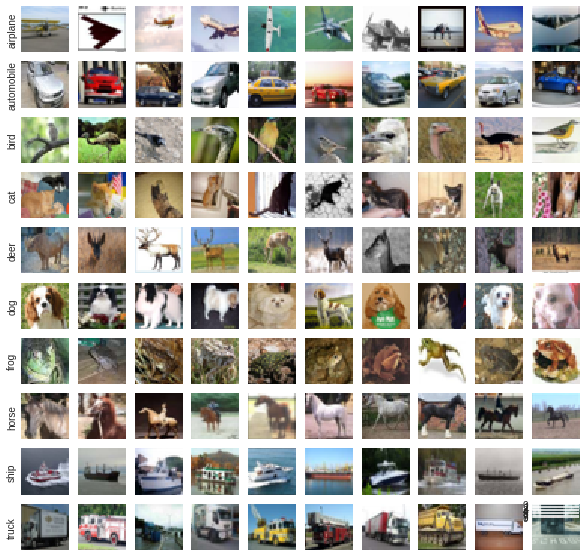

In [12]:
visualise_data(valid_df, classes, 10)

## Preparing DataLoaders
#### Pytorch Dataset

In [13]:
class CifarProvider(Dataset):
    def __init__(self, df, transform=None):
        self._df = df
        self._transform = transform
        
    def __len__(self):
        return len(self._df)
    
    def __getitem__(self, idx):
        row = self._df.iloc[idx]
        path, label = row['path'], row['label']
        img = Image.open(path)
        if not self._transform is None:
            img = self._transform(img)
        
        return img, label

#### Transformations 

In [14]:
train_transform = transforms.Compose([
    transforms.Resize((36, 36)),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
])

#### DataLoaders

In [15]:
train_provider = CifarProvider(train_df, train_transform)
train_loader = DataLoader(train_provider, batch_size=256, shuffle=True, num_workers=4)

valid_provider = CifarProvider(valid_df, test_transform)
valid_loader = DataLoader(valid_provider, batch_size=128, shuffle=False, num_workers=4)

dataloaders = {
    'train': train_loader,
    'valid': valid_loader,
}

## Tool for training visualisation

In [16]:
class Summary:
    def __init__(self):
        self._epochs = {
            'train': [],
            'valid': []
        }
        self._losses = {
            'train': [],
            'valid': []
        }
        self._accuracies = {
            'train': [],
            'valid': []
        }
        
    def add(self, epoch, loss, accuracy, phase):
        assert phase in ['train', 'valid']
        self._epochs[phase].append(epoch)
        self._losses[phase].append(loss)
        self._accuracies[phase].append(accuracy)
        
    def plot(self, figsize):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].plot(self._epochs['train'], self._losses['train'], label='Train')
        axes[0].plot(self._epochs['valid'], self._losses['valid'], label='Valid')
        axes[0].set_title('Loss Plot')
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        
        axes[1].plot(self._epochs['train'], self._accuracies['train'], label='Train')
        axes[1].plot(self._epochs['valid'], self._accuracies['valid'], label='Valid')
        axes[1].set_title('Accuracy Plot')
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Accuracy [%]')
        axes[1].legend()
        
        plt.show()

## Neural Network
#### Device selection {GPU/CPU}

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Architecture

In [18]:
model = models.densenet121(pretrained=True)

num_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, len(classes)),
    nn.Softmax(dim=1)
)

model = model.to(device)

#### Other training stuff

In [19]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True)

scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[150, 250] , gamma=0.1)

## Training

In [20]:
def train(model, dataloaders, criterion, optimizer, scheduler, epochs, test_epochs):
    summary = Summary()
    start = time.time()
    best_acc, best_weights = 0, copy.deepcopy(model.state_dict)
    
    try:
        for epoch in tqdm(range(epochs)):
            model.train()
            scheduler.step(epoch)
            train_loss, corrects = 0, 0
            for data, y_true in dataloaders['train']:
                data = data.to(device)
                y_true = y_true.to(device)

                optimizer.zero_grad()
                y_pred = model(data)

                loss = criterion(y_pred, y_true)

                loss.backward()
                optimizer.step()

                train_loss += loss.item() * data.size(0)
                corrects += torch.sum(torch.argmax(y_pred, dim=1) == y_true).item()
            train_loss /= len(dataloaders['train'].dataset)
            train_acc = corrects / len(dataloaders['train'].dataset) * 100
            summary.add(epoch=epoch, loss=train_loss, accuracy=train_acc, phase='train')


            if epoch % test_epochs == 0:
                model.eval()
                test_loss, corrects = 0, 0
                for data, y_true in dataloaders['valid']:
                    data = data.to(device)
                    y_true = y_true.to(device)

                    y_pred = model(data)

                    loss = criterion(y_pred, y_true)

                    test_loss += loss.item() * data.size(0)
                    corrects += torch.sum(torch.argmax(y_pred, dim=1) == y_true).item()
                test_loss /= len(dataloaders['valid'].dataset)
                test_acc = corrects / len(dataloaders['valid'].dataset) * 100
                summary.add(epoch=epoch, loss=test_loss, accuracy=test_acc, phase='valid')

                print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Valid Loss: {test_loss:.4f}, Valid Acc: {test_acc:.2f}%')

                if test_acc > best_acc:
                    best_acc = test_acc
                    best_weights = copy.deepcopy(model.state_dict())
    except KeyboardInterrupt:
        pass
    
    except Exception as e:
        print(e)
        
    finally:
        time_elapsed = time.time() - start
        print(f'Training complete in {(time_elapsed // 60):.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        return best_weights, summary
        

In [21]:
best_weights, summary = train(model, dataloaders, criterion, optimizer, scheduler, epochs=350, test_epochs=10)

Epoch: 0, Train Loss: 1.9101, Train Acc: 54.89%, Valid Loss: 1.9415, Valid Acc: 51.88%
Epoch: 10, Train Loss: 1.6615, Train Acc: 79.90%, Valid Loss: 1.6988, Valid Acc: 76.02%
Epoch: 20, Train Loss: 1.6184, Train Acc: 84.28%, Valid Loss: 1.6820, Valid Acc: 77.80%
Epoch: 30, Train Loss: 1.5945, Train Acc: 86.71%, Valid Loss: 1.6739, Valid Acc: 78.58%
Epoch: 40, Train Loss: 1.5851, Train Acc: 87.70%, Valid Loss: 1.6598, Valid Acc: 80.12%
Epoch: 50, Train Loss: 1.5828, Train Acc: 87.86%, Valid Loss: 1.6617, Valid Acc: 79.78%
Epoch: 60, Train Loss: 1.5757, Train Acc: 88.62%, Valid Loss: 1.6627, Valid Acc: 79.66%
Epoch: 70, Train Loss: 1.5727, Train Acc: 88.90%, Valid Loss: 1.6959, Valid Acc: 76.48%
Epoch: 80, Train Loss: 1.5704, Train Acc: 89.15%, Valid Loss: 1.6723, Valid Acc: 78.90%
Epoch: 90, Train Loss: 1.5712, Train Acc: 89.04%, Valid Loss: 1.6632, Valid Acc: 79.66%
Epoch: 100, Train Loss: 1.5642, Train Acc: 89.75%, Valid Loss: 1.6603, Valid Acc: 80.08%
Epoch: 110, Train Loss: 1.5616, 

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _fee

In [26]:
torch.save(best_weights, '../models/densenet_original')

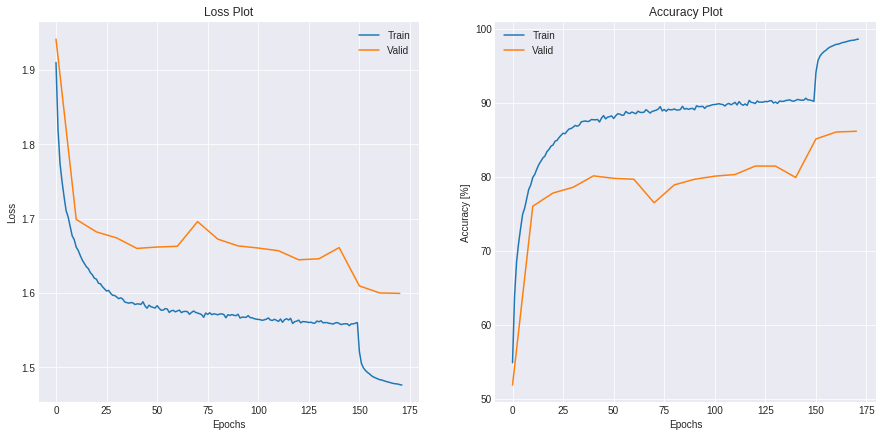

In [27]:
summary.plot(figsize=(15, 7))

In [24]:
# state_dict = torch.load('../models/densenet_500')
# model.load_state_dict(state_dict) 

In [25]:
summary._accuracies['train'][-1]

98.58666666666667